![Henry Logo](https://www.soyhenry.com/_next/static/media/HenryLogo.bb57fd6f.svg)

# Comparacion de Modelos de Embeddings: Small vs Large con Rayuela

## Objetivos de Aprendizaje

Al completar esta notebook seras capaz de:

1. **Comparar** los modelos `text-embedding-3-small` (1536d) y `text-embedding-3-large` (3072d) de OpenAI
2. **Medir** diferencias en costo, velocidad y calidad de representacion entre ambos modelos
3. **Visualizar** matrices de similitud coseno y analizar el rango dinamico de cada modelo
4. **Aplicar** PCA y t-SNE para explorar la estructura geometrica de los embeddings
5. **Evaluar** la granularidad semantica que cada modelo captura en textos literarios complejos
6. **Indexar** embeddings en ChromaDB y comparar rendimiento de indexacion
7. **Construir** pipelines RAG comparativos con LangChain LCEL
8. **Decidir** que modelo usar segun el caso de uso, presupuesto y requerimientos de calidad

### Prerequisitos

- Haber completado **01-bases-vectoriales-fundamentos** (conceptos de embeddings y similitud)
- Haber completado **02-bases-vectoriales-produccion** (ChromaDB, LangChain, RAG)

---

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken
import chromadb
import time
import sys
import warnings

from dotenv import find_dotenv, load_dotenv
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

warnings.filterwarnings('ignore')

load_dotenv(find_dotenv())
client = OpenAI()

# Constantes
MODEL_SMALL = "text-embedding-3-small"
MODEL_LARGE = "text-embedding-3-large"
DIMS_SMALL = 1536
DIMS_LARGE = 3072
PRECIO_SMALL = 0.02   # USD por 1M tokens
PRECIO_LARGE = 0.13   # USD por 1M tokens

encoder = tiktoken.encoding_for_model("text-embedding-3-small")

print("Todas las dependencias cargadas correctamente.")

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Todas las dependencias cargadas correctamente.


---

## 2. Teoria: Por que importa la dimensionalidad

Los modelos de embeddings de OpenAI ofrecen dos variantes con diferentes capacidades:

| Caracteristica | `text-embedding-3-small` | `text-embedding-3-large` |
|---|---|---|
| **Dimensiones** | 1,536 | 3,072 |
| **Costo** | $0.02 / 1M tokens | $0.13 / 1M tokens |
| **MTEB Average** | 62.3% | 64.6% |
| **Tamanio por vector** | ~6 KB | ~12 KB |
| **Caso de uso ideal** | Produccion a escala, busqueda general | Alta precision, matices semanticos finos |

### La analogia de la camara

Piensa en los embeddings como fotografias del significado de un texto:

- **Small (1536d)** = Camara de 12 megapixeles: excelente para la mayoria de usos cotidianos
- **Large (3072d)** = Camara de 24 megapixeles: captura detalles que solo importan cuando haces zoom

La pregunta clave no es "cual es mejor" sino **"que nivel de detalle necesito para mi caso de uso?"**

### Por que Rayuela como corpus

*Rayuela* de Julio Cortazar es el corpus ideal para esta comparacion porque:

- **Variedad tematica extrema**: amor, filosofia, absurdo, metaliteratura, musica, lenguaje inventado
- **Registros multiples**: lirico, narrativo, ensayistico, experimental
- **Complejidad semantica**: un modelo mediocre confundira todos los pasajes; uno bueno los separara
- **Riqueza literaria**: textos que desafian la capacidad representacional de cualquier modelo

---

## 3. El Corpus: 8 pasajes de Rayuela

In [2]:
pasajes = [
    {
        "id": "cap07",
        "capitulo": 7,
        "titulo": "Toco tu boca",
        "tema": "amor",
        "mood": "lirico",
        "registro": "poetico",
        "texto": (
            "Toco tu boca, con un dedo toco el borde de tu boca, voy dibujandola como si saliera de mi mano, "
            "como si por primera vez tu boca se entreabriera, y me basta cerrar los ojos para deshacerlo todo y "
            "recomenzar, hago nacer cada vez la boca que deseo, la boca que mi mano elige y te dibuja en la cara, "
            "una boca elegida entre todas, con soberana libertad elegida por mi para dibujarla con mi mano en tu "
            "cara, y que por un azar que no busco comprender coincide exactamente con tu boca que sonrie por "
            "debajo de la que mi mano te dibuja. Me miras, de cerca me miras, cada vez mas de cerca y entonces "
            "jugamos al ciclope, nos miramos cada vez mas de cerca y los ojos se agrandan, se acercan entre si, "
            "se superponen y los ciclopes se miran, respirando confundidos, las bocas se encuentran y luchan "
            "tibiamente, mordiendose con los labios, apoyando apenas la lengua en los dientes, jugando en sus "
            "recintos donde un aire pesado va y viene con un perfume viejo y un silencio. Entonces mis manos "
            "buscan hundirse en tu pelo, acariciar lentamente la profundidad de tu pelo mientras nos besamos "
            "como si tuvieramos la boca llena de flores o de peces, de movimientos vivos, de fragancia oscura. "
            "Y si nos mordemos el dolor es dulce, y si nos ahogamos en un breve y terrible absorber simultaneo "
            "del aliento, esa instantanea muerte es bella. Y ya ni siquiera tengo que tocarte, me basta cerrar "
            "los ojos y todo empieza, una vez mas puedo hacerte nacer, tomarte como el ciclope el sol, como un "
            "pedazo de mar entre mis labios, como la niebla que trepa de noche hasta mi ventana."
        )
    },
    {
        "id": "cap01",
        "capitulo": 1,
        "titulo": "Encontraria a la Maga?",
        "tema": "busqueda",
        "mood": "melancolico",
        "registro": "narrativo",
        "texto": (
            "Encontraria a la Maga? Tantas veces me habia bastado asomarme, viniendo por la rue de Seine, al arco "
            "que da al Quai de Conti, y apenas la luz de ceniza y olivo que flota sobre el rio me dejaba distinguir "
            "las formas, ya su silueta delgada se inscribia en el Pont des Arts, a veces andando de un lado a otro, "
            "a veces detenida en el pretil de hierro, inclinada sobre el agua. Y era tan natural cruzar la calle, "
            "subir los peldanos del puente, entrar en su delgada cintura y acercarme a la Maga que sonreia sin "
            "sorpresa, convencida como yo de que un encuentro casual era lo menos casual en nuestras vidas, y que "
            "la gente que se da citas precisas es la misma que necesita papel rayado para escribirse o que aprieta "
            "desde abajo el tubo de dentifrico. Pero ella no estaria ahora en el puente. Su fina cara de translucida "
            "piel se asomaria a viejos portales en el ghetto del Marais, quiza estuviera charlando con una "
            "vendedora de papas fritas o comiendo una salchicha caliente en el boulevard de Sebastopol. De todas "
            "maneras subi hasta el puente y la Maga no estaba. Ahora la Maga no estaba en mi camino, y aunque "
            "conociamos nuestros domicilios, cada hueco de nuestras dos habitaciones de falsos estudiantes en "
            "Paris, cada vez que andabamos por ahi para encontrarnos nos venia bien una teoria, porque "
            "andabamos sin buscarnos pero sabiendo que andabamos para encontrarnos. Oh Maga, en cada mujer "
            "parecida a vos se agolpaba como un silencio ensordecedor, una pausa filosa y cristalina que acababa "
            "por derrumbarse tristemente, como un paraguas mojado que se cierra."
        )
    },
    {
        "id": "cap36",
        "capitulo": 36,
        "titulo": "Reflexiones de Morelli sobre la novela",
        "tema": "filosofia",
        "mood": "reflexivo",
        "registro": "ensayistico",
        "texto": (
            "Morelli entendia que el mero escribir estetico era un escamoteo y una mentira, que acababa por "
            "suscitar al lector-hembra, al tipo que no quiere problemas sino soluciones, o falsos problemas ajenos "
            "que le permiten sufrir comodamente sentado en su sillon, sin comprometerse en el drama que tambien "
            "deberia ser el suyo. En Argentina, donde ese tipo de lector proliferaba con razon, el escritor que no "
            "quisiera ir mas alla de las capacidades de su clase deberia escribir laboriosamente para ese lector, "
            "cuidandose de no molestarlo con noticias demasiado fuertes. El problema para Morelli estaba en que "
            "habia sentido desde siempre que las grandes obras narrativas se habian escrito con una sola "
            "intencion verdadera aunque multiples propositos la disfrazaran: provocar una apertura, quebrar la "
            "costumbre, obligar al lector a participar casi a pesar suyo, sumiendolo en un territorio donde la "
            "palabra era materia moldeable, algo que se podia romper y rehacer. Las tecnicas, las teorias, los "
            "hallazgos formales que jalonaban la historia de la literatura no eran mas que huellas del avance "
            "hacia ese encuentro definitivo con el lector, hacia una comunicacion que no fuese estetica sino vital, "
            "que no apelase al sentimiento sino a la conciencia, que no buscase ser admirada sino ser vivida. "
            "La novela deberia ser como esos dibujos que proponen los psicologos de la Gestalt, y asi ciertas "
            "lineas inducirian al observador a trazar imaginativamente las que cerraban la figura. Con lo cual "
            "la obra se completaria no ya por el autor sino por el lector, alcanzando asi la verdadera "
            "comunicacion literaria."
        )
    },
    {
        "id": "cap68",
        "capitulo": 68,
        "titulo": "El Gliglico",
        "tema": "lenguaje_inventado",
        "mood": "ludico",
        "registro": "experimental",
        "texto": (
            "Apenas el le amalaba el noema, a ella se le agolpaba el clemiso y caian en hidromurias, en salvajes "
            "ambonias, en sustalos exasperantes. Cada vez que el procuraba relamar las incopelusas, se enredaba "
            "en un grimado quejumbroso y tenia que envulsionarse de cara al novalo, sintiendo como poco a poco "
            "las arnillas se espejunaban, se iban apeltronando, reduplimiendo, hasta quedar tendido como el "
            "trimalciato de ergomanina al que se le han dejado caer unas filulas de cariaconcia. Y sin embargo "
            "era apenas el principio, porque en un momento dado ella se torcia los hurgalios, consintiendo en que "
            "el aproximara suavemente sus orfelunios. Apenas se entreplumaban, algo como un ulucordio los "
            "encrestoriaba, los extrayuxtaba y paramovía, de pronto era el clinon, la esterfurosa convulcante "
            "de las matricas, la jadehollante embocapluvia del orgumio, los esjasmos del merpasmo en una "
            "sobrehumítica agopausa. Evohé! Evohé! Volposados en la cresta del murelio, un profuso de "
            "masjinculas la jadsjaba en un gosjante cuñiflujo de sjadsjadas jasjíneas. Y ahora era ella quien se "
            "agsjolpaba en un sjincope de sjíntesjos y sjamores, sjumiendosjé en las sjuperjóricas sjofaldas "
            "del orgsjumo, con los sjuspiros de la sjuprema sjatisfacción."
        )
    },
    {
        "id": "cap73",
        "capitulo": 73,
        "titulo": "Critica del lector pasivo",
        "tema": "metaliteratura",
        "mood": "critico",
        "registro": "ensayistico",
        "texto": (
            "El tipo que quiere una novela cerrada, netamente terminada, y no un orden abierto donde la vida y la "
            "escritura se entrelacen como esas cintas de Moebius que tanto fascinaban a Morelli, ese tipo necesita "
            "que le den todo masticado. Lo cual es absolutamente legitimo en el terreno de las transacciones "
            "comerciales, en el de las relaciones sentimentales corrientes, en el de la cocina y las finanzas. "
            "Pero un libro es otra cosa: ahi donde el lector deberia ser un complice, un camarada de camino, "
            "alguien que arrima el hombro y suda con los personajes, ese lector-hembra prefiere el confort del "
            "sillon, la zapatilla al lado de la lampara, y que le cuenten como fue que le fue a la chica sin que "
            "tenga que mancharse los dedos con la tinta de la historia. Morelli queria que su libro fuese como "
            "un agujero en el suelo, algo que obligase al lector a saltar, a caer quiza al otro lado del mundo "
            "o quiza a ningun lado, pero que lo arrancase de la poltrona, de las certidumbres tibias, del orden "
            "domestico de los tres platos y el diario de la manana. Un libro como una manzana inesperada en la "
            "cabeza de Newton: algo que desordena, que obliga a preguntarse por que diablos caen las manzanas "
            "y no suben. Porque la verdad es que el lector-hembra quiere que las manzanas suban, o que se "
            "queden flotando ahi donde estan, bonitas y tranquilas como manzanas de cera en un frutero."
        )
    },
    {
        "id": "cap28",
        "capitulo": 28,
        "titulo": "El concierto de Berthe Trepat",
        "tema": "musica",
        "mood": "tragico",
        "registro": "narrativo",
        "texto": (
            "Oliveira se habia quedado solo en la sala porque los otros oyentes se habian ido uno a uno durante "
            "el intervalo de los supuestos tres tiempos de la Sintesis Dolorier-Krepps que Berthe Trepat "
            "interpretaba sin vacilar. Oliveira tenia verguenza por la pianista, sentia una especie de lastima "
            "horrible mezclada con ganas de reirse, porque la vieja tecleaba furiosamente mirando de tanto en "
            "tanto al publico que se reducia ya a Oliveira y a una senora de cabellos plateados que dormitaba "
            "inclinada sobre su paraguas. La musica de la Sintesis era atroz, con pasajes donde el piano sonaba "
            "como si alguien estuviera golpeando chapas con un martillo, y otros momentos de una dulzura "
            "siruposa en que Berthe Trepat cerraba los ojos e inclinaba la cabeza sobre el teclado como si "
            "rezara, y era peor que los martillazos porque habia algo de pretension, de falsa profundidad, "
            "una cursileria tan descomunal que Oliveira solo atinaba a mirar el suelo o el cielo raso. Y sin "
            "embargo se quedaba, se quedaba porque la vieja estaba tan sola ahi arriba en el estrado con la "
            "Sintesis Dolorier-Krepps, y era imposible no pensar que detras de esa cortina de sonidos "
            "exasperantes habia una persona, alguien que necesitaba de su presencia aunque fuese unicamente "
            "la presencia de un cuerpo caliente sentado en una butaca. La compasion se le retorcia en el "
            "estomago como un gato que no quiere que lo banen."
        )
    },
    {
        "id": "cap93",
        "capitulo": 93,
        "titulo": "Notas de Morelli sobre la narrativa",
        "tema": "metaliteratura",
        "mood": "reflexivo",
        "registro": "ensayistico",
        "texto": (
            "Morelli habia pensado una lista de acknowledgments que nunca llego a usar pero que se encontro "
            "entre sus papeles. Dejando de lado los agradecimientos mas o menos sarcasticos a editores y "
            "correctores de pruebas, la parte util de la lista se reducia a una serie de notas sobre la novela. "
            "En una de ellas Morelli anotaba: 'Intentar el roman comique en el sentido en que un texto alcance "
            "a insinuar otros valores y colabore asi en esa antropofania que seguimos creyendo posible. Parece "
            "una empresa desesperada, pero la novela que nos interesa no es la que va colocando los personajes "
            "en la situacion, sino la que instala la situacion en los personajes. Con lo cual estos dejan de ser "
            "personajes para volverse personas vivientes.' En otra nota: 'La novela contemporanea se contenta "
            "con un orden cerrado. Resueltamente en contra, buscar tambien aqui la apertura y para eso cortar "
            "de raiz toda construccion sistematica de caracteres y situaciones. Metodo: la ironia, la autocritica "
            "incesante, la incongruencia, la imaginacion al servicio de nadie.' Y mas abajo: 'Provocar, asumir "
            "un texto desaliñado, desanudado, incongruente, minuciosamente antinovelístico (aunque no "
            "antinovelesco). Sin vedarse los grandes efectos del genero cuando la situacion lo requiera, pero "
            "recordando el consejo gidiano: ne jamais profiter de l'elan acquis. Como todas las criaturas de "
            "eleccion del Occidente, la novela se contenta con un orden cerrado. Resueltamente en contra, "
            "buscar tambien aqui la apertura.'"
        )
    },
    {
        "id": "cap56",
        "capitulo": 56,
        "titulo": "El tablon entre ventanas",
        "tema": "absurdo",
        "mood": "absurdo",
        "registro": "narrativo",
        "texto": (
            "Traveler se asomo a la ventana y vio a Oliveira sentado en la ventana de su pieza, en el segundo "
            "piso del hotel que quedaba enfrente. Oliveira habia tendido un par de tablones desde su ventana "
            "hasta la de Traveler, y le hacia senas para que cruzara por los tablones. 'Estas completamente "
            "loco', le dijo Traveler. 'Es la unica forma', dijo Oliveira. 'Vos no queres bajar la escalera y "
            "cruzar la calle y subir la escalera? No seas vago, son apenas doce escalones de un lado y doce del "
            "otro.' Pero Oliveira insistia en que los tablones eran necesarios, que habia una cuestion de "
            "principios. 'Si bajamos a la calle nos vamos a contaminar con las convenciones', decia Oliveira. "
            "'La calle esta llena de pragmatismo, de gente que va y viene cumpliendo funciones, de semaforos "
            "y policias. Arriba, entre tu ventana y la mia, hay una zona liberada, un territorio que todavia "
            "es nuestro.' Traveler lo miraba pensando que a lo mejor tenia razon, o que se habia vuelto "
            "completamente loco, lo cual en el fondo venia a ser lo mismo. Talita, que habia llegado con los "
            "mates, dijo que ella no pensaba cruzar por ningun tablon, y que si querian yerba iban a tener "
            "que encontrar un metodo de transporte menos existencialista. Entonces Oliveira propuso atar un "
            "hilo entre las dos ventanas y pasar los mates en una cesta, como un teleferico de la locura, "
            "y asi estuvieron toda la tarde inventando mecanismos absurdos para no hacer lo que cualquier "
            "persona en su sano juicio habria hecho: bajar por la escalera."
        )
    }
]

print(f"Corpus cargado: {len(pasajes)} pasajes de Rayuela")
print(f"Capitulos: {[p['capitulo'] for p in pasajes]}")

Corpus cargado: 8 pasajes de Rayuela
Capitulos: [7, 1, 36, 68, 73, 28, 93, 56]


In [3]:
# Tabla resumen del corpus con conteo de caracteres y tokens
resumen = []
for p in pasajes:
    tokens = encoder.encode(p["texto"])
    resumen.append({
        "ID": p["id"],
        "Capitulo": p["capitulo"],
        "Titulo": p["titulo"],
        "Tema": p["tema"],
        "Mood": p["mood"],
        "Registro": p["registro"],
        "Caracteres": len(p["texto"]),
        "Tokens": len(tokens)
    })

df_corpus = pd.DataFrame(resumen)
print(f"Total tokens en corpus: {df_corpus['Tokens'].sum():,}")
print(f"Promedio tokens por pasaje: {df_corpus['Tokens'].mean():.0f}")
print()
df_corpus

Total tokens en corpus: 3,263
Promedio tokens por pasaje: 408



,ID,Capitulo,Titulo,Tema,Mood,Registro,Caracteres,Tokens
0,cap07,7,Toco tu boca,amor,lirico,poetico,1549,445
1,cap01,1,Encontraria a la Maga?,busqueda,melancolico,narrativo,1552,443
2,cap36,36,Reflexiones de Morelli sobre la novela,filosofia,reflexivo,ensayistico,1589,416
3,cap68,68,El Gliglico,lenguaje_inventado,ludico,experimental,1219,403
4,cap73,73,Critica del lector pasivo,metaliteratura,critico,ensayistico,1364,387
5,cap28,28,El concierto de Berthe Trepat,musica,tragico,narrativo,1378,377
6,cap93,93,Notas de Morelli sobre la narrativa,metaliteratura,reflexivo,ensayistico,1481,393
7,cap56,56,El tablon entre ventanas,absurdo,absurdo,narrativo,1489,399


---

## 4. Generacion de Embeddings y Benchmarking

In [4]:
textos = [p["texto"] for p in pasajes]
etiquetas = [f"Cap {p['capitulo']}\n{p['tema']}" for p in pasajes]
etiquetas_cortas = [f"Cap {p['capitulo']}" for p in pasajes]

# Generar embeddings con text-embedding-3-small
t0 = time.perf_counter()
resp_small = client.embeddings.create(input=textos, model=MODEL_SMALL)
tiempo_small = time.perf_counter() - t0
emb_small = np.array([e.embedding for e in resp_small.data])

# Generar embeddings con text-embedding-3-large
t0 = time.perf_counter()
resp_large = client.embeddings.create(input=textos, model=MODEL_LARGE)
tiempo_large = time.perf_counter() - t0
emb_large = np.array([e.embedding for e in resp_large.data])

total_tokens = df_corpus["Tokens"].sum()

print(f"{'Metrica':<25} {'Small':>12} {'Large':>12}")
print("-" * 50)
print(f"{'Dimensiones':<25} {DIMS_SMALL:>12,} {DIMS_LARGE:>12,}")
print(f"{'Tokens procesados':<25} {total_tokens:>12,} {total_tokens:>12,}")
print(f"{'Tiempo (s)':<25} {tiempo_small:>12.3f} {tiempo_large:>12.3f}")
print(f"{'Bytes por vector':<25} {DIMS_SMALL * 4:>12,} {DIMS_LARGE * 4:>12,}")
print(f"{'Costo estimado (USD)':<25} {total_tokens / 1e6 * PRECIO_SMALL:>12.6f} {total_tokens / 1e6 * PRECIO_LARGE:>12.6f}")
print(f"{'Shape':<25} {str(emb_small.shape):>12} {str(emb_large.shape):>12}")

Metrica                          Small        Large
--------------------------------------------------
Dimensiones                      1,536        3,072
Tokens procesados                3,263        3,263
Tiempo (s)                       0.760        0.646
Bytes por vector                 6,144       12,288
Costo estimado (USD)          0.000065     0.000424
Shape                        (8, 1536)    (8, 3072)


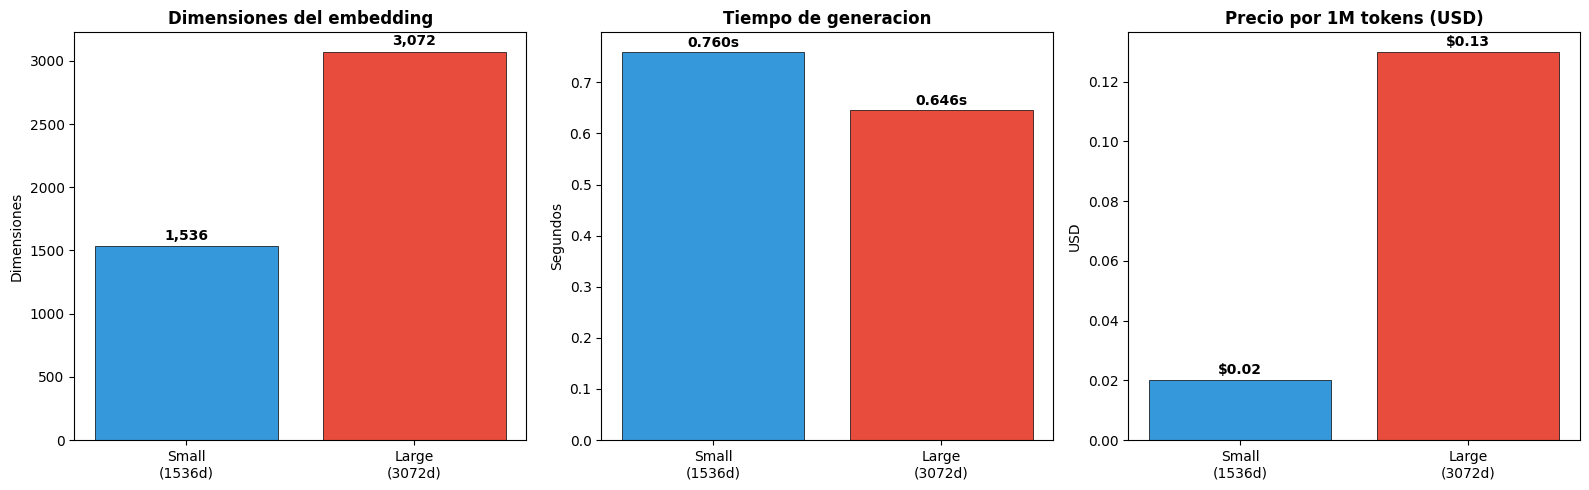

In [5]:
# Visualizacion: grafico de barras 3-paneles (dimensiones, tiempo, precio)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
modelos = ["Small\n(1536d)", "Large\n(3072d)"]
colores = ["#3498db", "#e74c3c"]

# Panel 1: Dimensiones
axes[0].bar(modelos, [DIMS_SMALL, DIMS_LARGE], color=colores, edgecolor='black', linewidth=0.5)
axes[0].set_title("Dimensiones del embedding", fontweight='bold')
axes[0].set_ylabel("Dimensiones")
for i, v in enumerate([DIMS_SMALL, DIMS_LARGE]):
    axes[0].text(i, v + 50, f"{v:,}", ha='center', fontweight='bold')

# Panel 2: Tiempo
axes[1].bar(modelos, [tiempo_small, tiempo_large], color=colores, edgecolor='black', linewidth=0.5)
axes[1].set_title("Tiempo de generacion", fontweight='bold')
axes[1].set_ylabel("Segundos")
for i, v in enumerate([tiempo_small, tiempo_large]):
    axes[1].text(i, v + 0.01, f"{v:.3f}s", ha='center', fontweight='bold')

# Panel 3: Precio
axes[2].bar(modelos, [PRECIO_SMALL, PRECIO_LARGE], color=colores, edgecolor='black', linewidth=0.5)
axes[2].set_title("Precio por 1M tokens (USD)", fontweight='bold')
axes[2].set_ylabel("USD")
for i, v in enumerate([PRECIO_SMALL, PRECIO_LARGE]):
    axes[2].text(i, v + 0.002, f"${v}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---

## 5. Matrices de Similitud (Heatmaps)

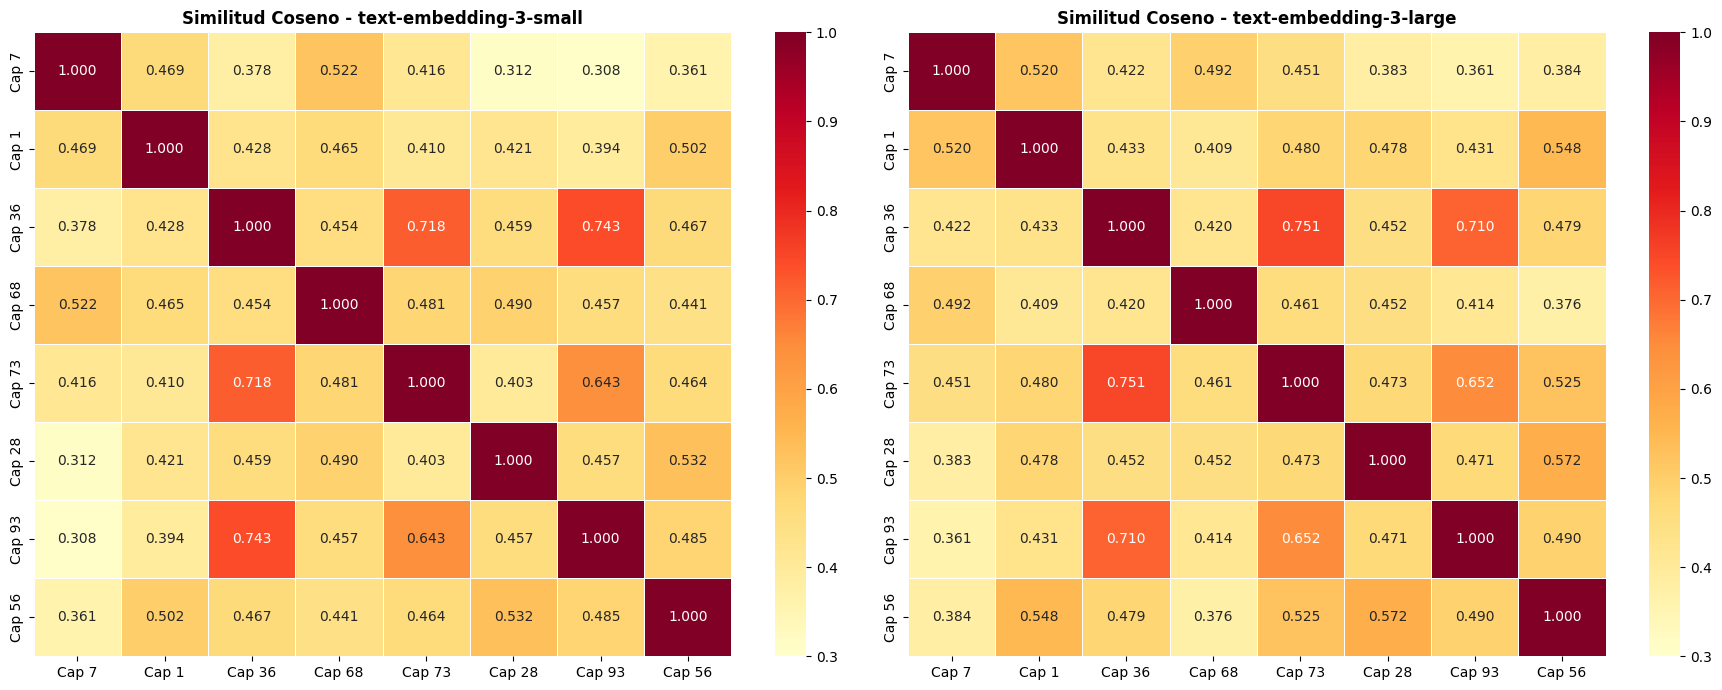

Metrica                        Small      Large
----------------------------------------------
Min similitud                 0.3078     0.3613
Max similitud                 0.7429     0.7511
Rango dinamico                0.4351     0.3898

Mayor rango dinamico = mejor capacidad de discriminacion entre pasajes.


In [6]:
# Calcular matrices de similitud coseno
sim_small = cosine_similarity(emb_small)
sim_large = cosine_similarity(emb_large)

# Heatmaps side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(sim_small, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=0.5,
            xticklabels=etiquetas_cortas, yticklabels=etiquetas_cortas, ax=axes[0],
            vmin=0.3, vmax=1.0)
axes[0].set_title(f"Similitud Coseno - {MODEL_SMALL}", fontweight='bold')

sns.heatmap(sim_large, annot=True, fmt='.3f', cmap='YlOrRd', linewidths=0.5,
            xticklabels=etiquetas_cortas, yticklabels=etiquetas_cortas, ax=axes[1],
            vmin=0.3, vmax=1.0)
axes[1].set_title(f"Similitud Coseno - {MODEL_LARGE}", fontweight='bold')

plt.tight_layout()
plt.show()

# Rango dinamico (max - min excluyendo diagonal)
def rango_dinamico(sim_matrix):
    mask = ~np.eye(sim_matrix.shape[0], dtype=bool)
    valores = sim_matrix[mask]
    return valores.max() - valores.min(), valores.min(), valores.max()

rango_s, min_s, max_s = rango_dinamico(sim_small)
rango_l, min_l, max_l = rango_dinamico(sim_large)

print(f"{'Metrica':<25} {'Small':>10} {'Large':>10}")
print("-" * 46)
print(f"{'Min similitud':<25} {min_s:>10.4f} {min_l:>10.4f}")
print(f"{'Max similitud':<25} {max_s:>10.4f} {max_l:>10.4f}")
print(f"{'Rango dinamico':<25} {rango_s:>10.4f} {rango_l:>10.4f}")
print(f"\nMayor rango dinamico = mejor capacidad de discriminacion entre pasajes.")

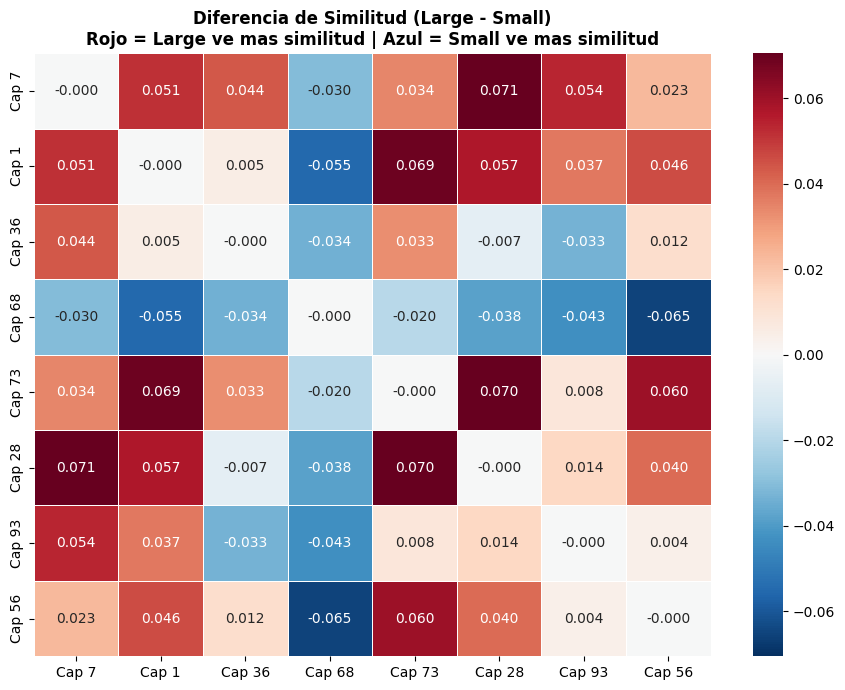

In [7]:
# Heatmap de diferencia (large - small)
diff_matrix = sim_large - sim_small

fig, ax = plt.subplots(figsize=(9, 7))
max_abs = max(abs(diff_matrix.min()), abs(diff_matrix.max()))

sns.heatmap(diff_matrix, annot=True, fmt='.3f', cmap='RdBu_r', linewidths=0.5,
            xticklabels=etiquetas_cortas, yticklabels=etiquetas_cortas, ax=ax,
            center=0, vmin=-max_abs, vmax=max_abs)
ax.set_title("Diferencia de Similitud (Large - Small)\nRojo = Large ve mas similitud | Azul = Small ve mas similitud",
             fontweight='bold')

plt.tight_layout()
plt.show()

---

## 6. Reduccion de Dimensionalidad (PCA y t-SNE)

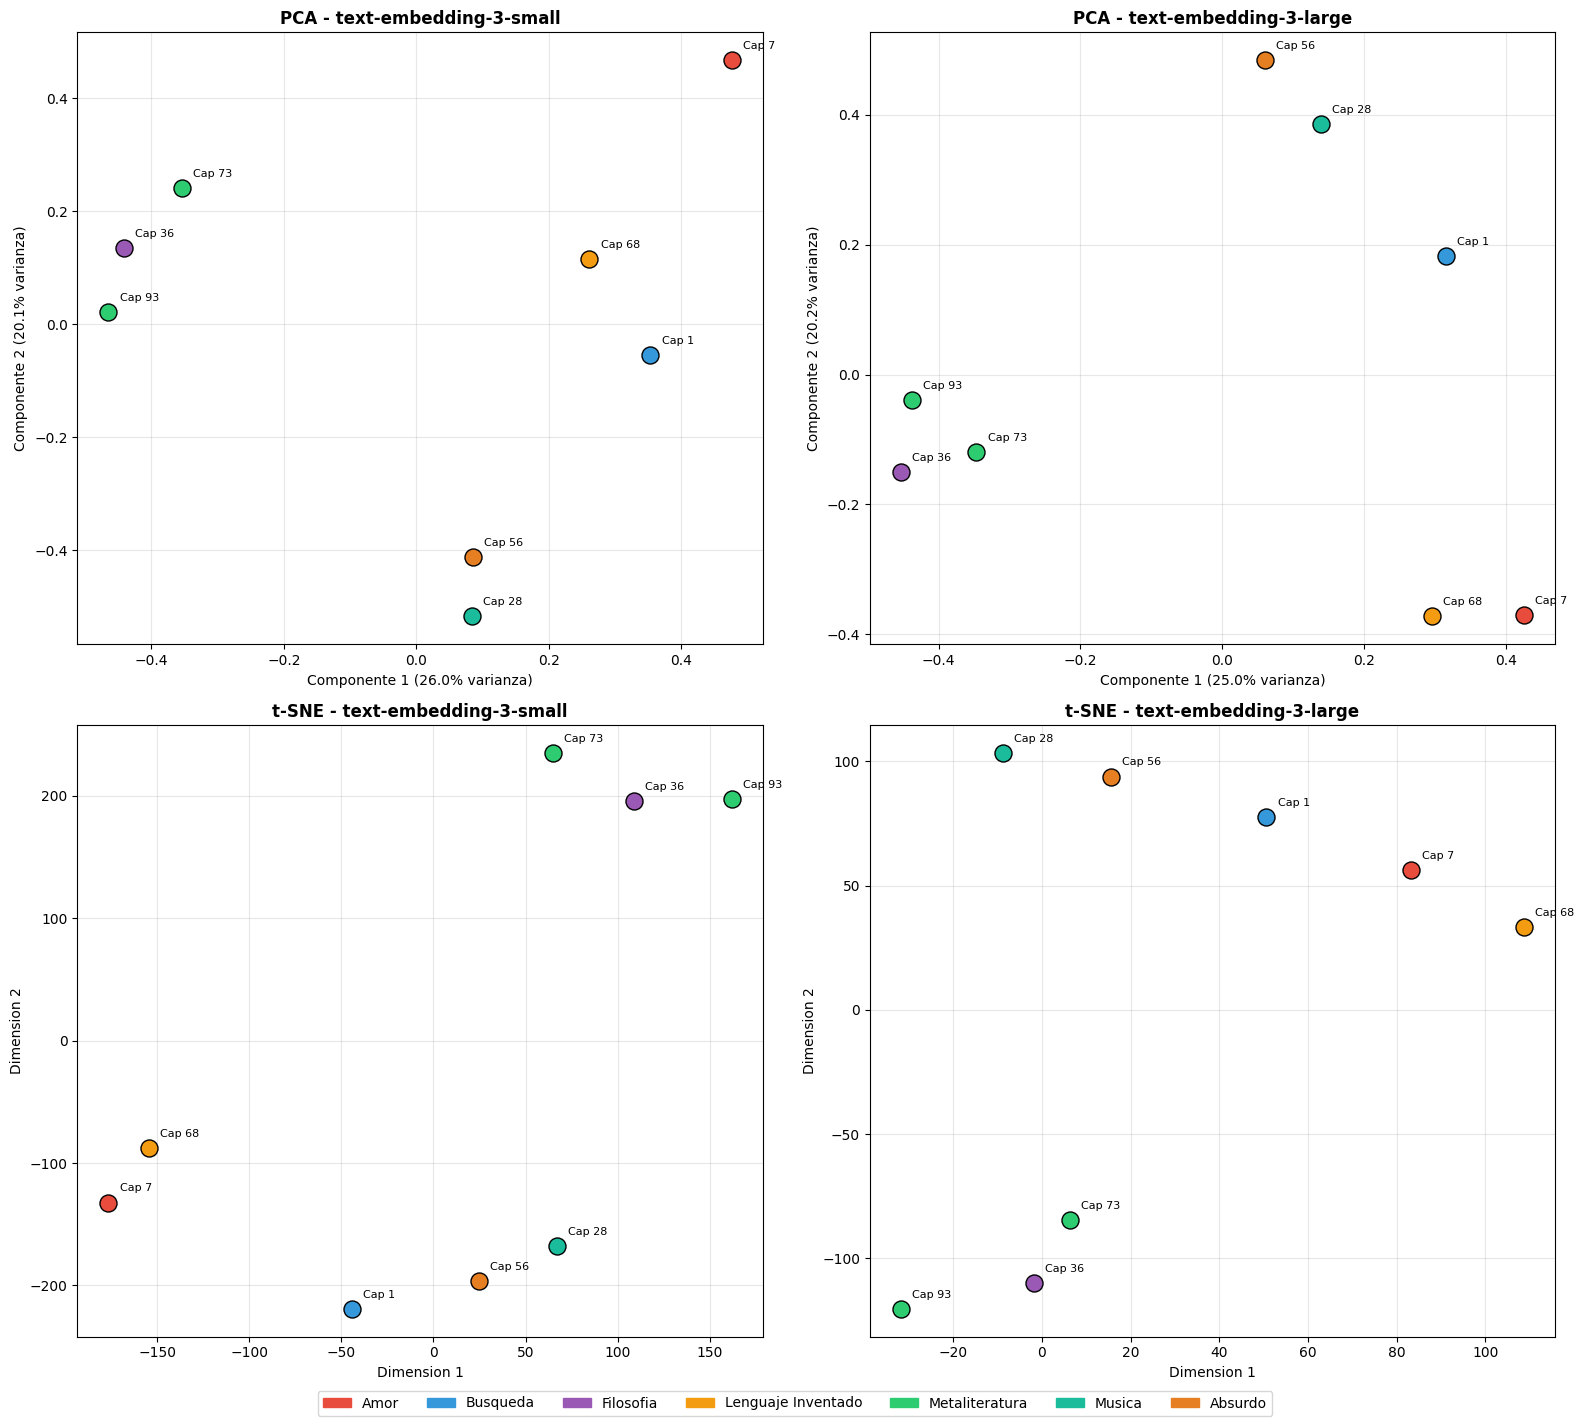

In [8]:
# Mapa de colores por tema
color_map = {
    "amor": "#e74c3c",
    "busqueda": "#3498db",
    "filosofia": "#9b59b6",
    "lenguaje_inventado": "#f39c12",
    "metaliteratura": "#2ecc71",
    "musica": "#1abc9c",
    "absurdo": "#e67e22"
}

temas = [p["tema"] for p in pasajes]
colores_puntos = [color_map[t] for t in temas]

# PCA para ambos modelos
pca_small = PCA(n_components=2).fit_transform(emb_small)
pca_large = PCA(n_components=2).fit_transform(emb_large)

pca_var_small = PCA(n_components=2).fit(emb_small).explained_variance_ratio_
pca_var_large = PCA(n_components=2).fit(emb_large).explained_variance_ratio_

# t-SNE para ambos modelos
tsne_small = TSNE(n_components=2, perplexity=2, random_state=42).fit_transform(emb_small)
tsne_large = TSNE(n_components=2, perplexity=2, random_state=42).fit_transform(emb_large)

# Visualizacion 2x2: PCA arriba, t-SNE abajo
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

def plot_scatter(ax, coords, title, var_info=None):
    for i, (x, y) in enumerate(coords):
        ax.scatter(x, y, c=colores_puntos[i], s=150, edgecolors='black', linewidth=1, zorder=3)
        ax.annotate(f"Cap {pasajes[i]['capitulo']}", (x, y),
                    textcoords="offset points", xytext=(8, 8), fontsize=8)
    if var_info is not None:
        ax.set_xlabel(f"Componente 1 ({var_info[0]*100:.1f}% varianza)")
        ax.set_ylabel(f"Componente 2 ({var_info[1]*100:.1f}% varianza)")
    else:
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
    ax.set_title(title, fontweight='bold')
    ax.grid(True, alpha=0.3)

plot_scatter(axes[0, 0], pca_small, f"PCA - {MODEL_SMALL}", pca_var_small)
plot_scatter(axes[0, 1], pca_large, f"PCA - {MODEL_LARGE}", pca_var_large)
plot_scatter(axes[1, 0], tsne_small, f"t-SNE - {MODEL_SMALL}")
plot_scatter(axes[1, 1], tsne_large, f"t-SNE - {MODEL_LARGE}")

# Leyenda compartida
import matplotlib.patches as mpatches
legend_handles = [mpatches.Patch(color=color_map[t], label=t.replace('_', ' ').title())
                  for t in color_map]
fig.legend(handles=legend_handles, loc='lower center', ncol=len(color_map),
           fontsize=10, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.show()

---

## 7. Analisis de Granularidad

In [9]:
# Pares de interes: similares tematicamente y contrastantes
pares_interes = [
    ("cap36", "cap93", "Ambos metaliteratura/filosofia (Morelli)"),
    ("cap73", "cap93", "Ambos metaliteratura (critica + notas)"),
    ("cap36", "cap73", "Filosofia vs metaliteratura"),
    ("cap07", "cap68", "Amor lirico vs gliglico (ambos sobre intimidad)"),
    ("cap07", "cap01", "Amor vs busqueda (misma relacion)"),
    ("cap07", "cap56", "Amor vs absurdo (contrastantes)"),
    ("cap68", "cap28", "Lenguaje inventado vs musica (experimentales)"),
    ("cap56", "cap28", "Absurdo vs musica (narrativos)"),
]

# Crear indice de IDs
id_to_idx = {p["id"]: i for i, p in enumerate(pasajes)}

resultados_pares = []
for id_a, id_b, descripcion in pares_interes:
    i, j = id_to_idx[id_a], id_to_idx[id_b]
    sim_s = sim_small[i, j]
    sim_l = sim_large[i, j]
    resultados_pares.append({
        "Par": f"Cap {pasajes[i]['capitulo']} vs Cap {pasajes[j]['capitulo']}",
        "Descripcion": descripcion,
        "Sim Small": sim_s,
        "Sim Large": sim_l,
        "Diferencia": sim_l - sim_s
    })

df_pares = pd.DataFrame(resultados_pares)
df_pares

,Par,Descripcion,Sim Small,Sim Large,Diferencia
0,Cap 36 vs Cap 93,Ambos metaliteratura/filosofia (Morelli),0.742916,0.709679,-0.033237
1,Cap 73 vs Cap 93,Ambos metaliteratura (critica + notas),0.643401,0.651751,0.008350
2,Cap 36 vs Cap 73,Filosofia vs metaliteratura,0.718103,0.751054,0.032952
3,Cap 7 vs Cap 68,Amor lirico vs gliglico (ambos sobre intimidad),0.521888,0.491517,-0.030371
4,Cap 7 vs Cap 1,Amor vs busqueda (misma relacion),0.468679,0.520066,0.051387
5,Cap 7 vs Cap 56,Amor vs absurdo (contrastantes),0.361203,0.384026,0.022823
6,Cap 68 vs Cap 28,Lenguaje inventado vs musica (experimentales),0.490260,0.452175,-0.038084
7,Cap 56 vs Cap 28,Absurdo vs musica (narrativos),0.531863,0.571913,0.040050


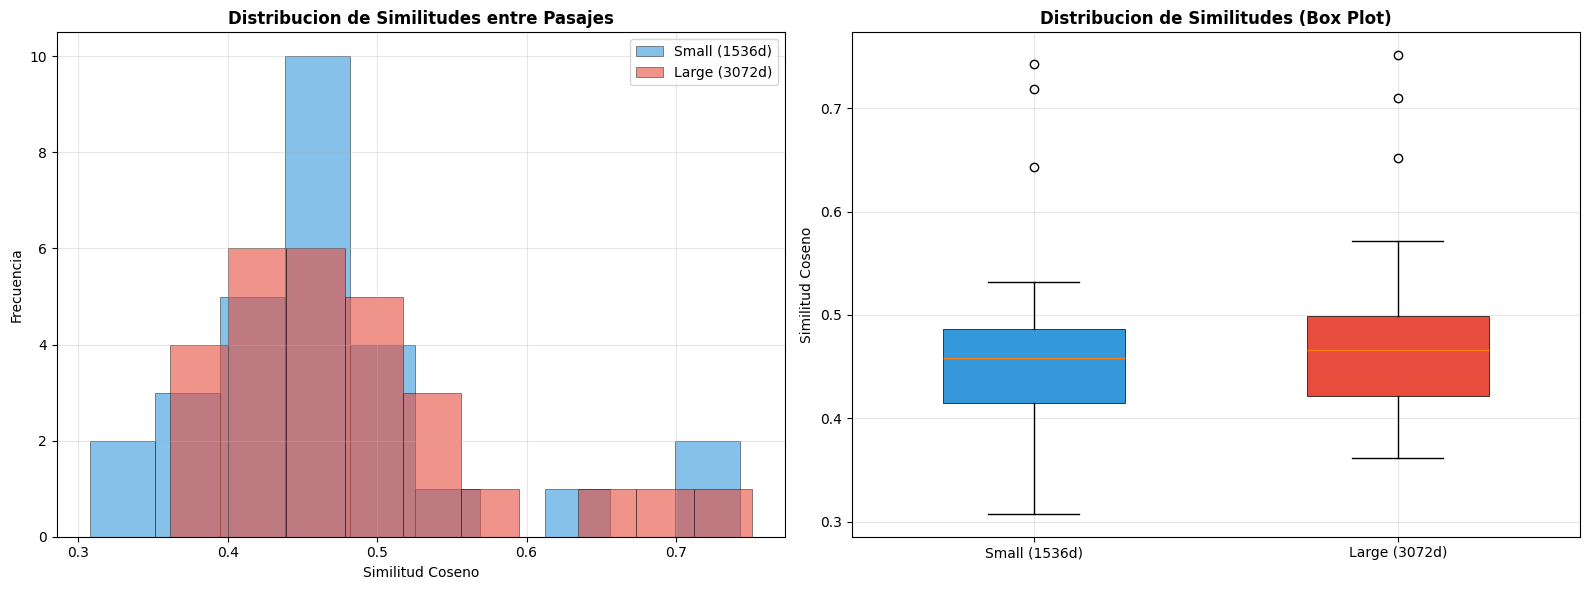

Estadistica               Small      Large
------------------------------------------
Media                    0.4672     0.4818
Desv. estandar           0.0979     0.0926
Minimo                   0.3078     0.3613
Maximo                   0.7429     0.7511


In [10]:
# Visualizacion: histograma superpuesto + box plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Extraer todos los valores de similitud (triangulo superior, sin diagonal)
mask_upper = np.triu_indices(len(pasajes), k=1)
vals_small = sim_small[mask_upper]
vals_large = sim_large[mask_upper]

# Histograma superpuesto
axes[0].hist(vals_small, bins=10, alpha=0.6, color='#3498db', label=f'Small (1536d)', edgecolor='black', linewidth=0.5)
axes[0].hist(vals_large, bins=10, alpha=0.6, color='#e74c3c', label=f'Large (3072d)', edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Similitud Coseno')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribucion de Similitudes entre Pasajes', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
bp = axes[1].boxplot([vals_small, vals_large], labels=['Small (1536d)', 'Large (3072d)'],
                     patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
for box in bp['boxes']:
    box.set(edgecolor='black', linewidth=0.5)
axes[1].set_ylabel('Similitud Coseno')
axes[1].set_title('Distribucion de Similitudes (Box Plot)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadisticas
print(f"{'Estadistica':<20} {'Small':>10} {'Large':>10}")
print("-" * 42)
print(f"{'Media':<20} {vals_small.mean():>10.4f} {vals_large.mean():>10.4f}")
print(f"{'Desv. estandar':<20} {vals_small.std():>10.4f} {vals_large.std():>10.4f}")
print(f"{'Minimo':<20} {vals_small.min():>10.4f} {vals_large.min():>10.4f}")
print(f"{'Maximo':<20} {vals_small.max():>10.4f} {vals_large.max():>10.4f}")

---

## 8. Indexacion en ChromaDB

In [11]:
chroma_client = chromadb.Client()

# Coleccion con embeddings small
t0 = time.perf_counter()
col_small = chroma_client.get_or_create_collection(name="rayuela_small")
col_small.add(
    documents=[p["texto"] for p in pasajes],
    metadatas=[{"capitulo": p["capitulo"], "titulo": p["titulo"], "tema": p["tema"],
                "mood": p["mood"], "registro": p["registro"]} for p in pasajes],
    ids=[p["id"] for p in pasajes],
    embeddings=emb_small.tolist()
)
tiempo_idx_small = time.perf_counter() - t0

# Coleccion con embeddings large
t0 = time.perf_counter()
col_large = chroma_client.get_or_create_collection(name="rayuela_large")
col_large.add(
    documents=[p["texto"] for p in pasajes],
    metadatas=[{"capitulo": p["capitulo"], "titulo": p["titulo"], "tema": p["tema"],
                "mood": p["mood"], "registro": p["registro"]} for p in pasajes],
    ids=[p["id"] for p in pasajes],
    embeddings=emb_large.tolist()
)
tiempo_idx_large = time.perf_counter() - t0

mem_small = sys.getsizeof(emb_small.tobytes())
mem_large = sys.getsizeof(emb_large.tobytes())

print(f"{'Metrica':<30} {'Small':>12} {'Large':>12}")
print("-" * 55)
print(f"{'Tiempo de indexacion (s)':<30} {tiempo_idx_small:>12.4f} {tiempo_idx_large:>12.4f}")
print(f"{'Memoria embeddings (KB)':<30} {mem_small/1024:>12.1f} {mem_large/1024:>12.1f}")
print(f"{'Documentos indexados':<30} {col_small.count():>12} {col_large.count():>12}")

Metrica                               Small        Large
-------------------------------------------------------
Tiempo de indexacion (s)             0.0191       0.0052
Memoria embeddings (KB)                96.0        192.0
Documentos indexados                      8            8


---

## 9. RAG Pipeline Comparativo

In [12]:
# Crear documentos LangChain
lc_docs = [
    Document(
        page_content=p["texto"],
        metadata={"capitulo": p["capitulo"], "titulo": p["titulo"], "tema": p["tema"],
                  "mood": p["mood"], "registro": p["registro"]}
    )
    for p in pasajes
]

# Vectorstores con LangChain
embeddings_small = OpenAIEmbeddings(model=MODEL_SMALL)
embeddings_large = OpenAIEmbeddings(model=MODEL_LARGE)

vectorstore_small = Chroma.from_documents(lc_docs, embeddings_small, collection_name="rag_small")
vectorstore_large = Chroma.from_documents(lc_docs, embeddings_large, collection_name="rag_large")

retriever_small = vectorstore_small.as_retriever(search_kwargs={"k": 3})
retriever_large = vectorstore_large.as_retriever(search_kwargs={"k": 3})

print("Vectorstores y retrievers creados para ambos modelos.")

Vectorstores y retrievers creados para ambos modelos.


In [13]:
# RAG Chain con LCEL
template = """Eres un experto en literatura latinoamericana. Responde la pregunta usando SOLO el contexto proporcionado.
Si no puedes responder con el contexto dado, dilo claramente.

Contexto:
{context}

Pregunta: {question}

Respuesta:"""

prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(model="gpt-4o", temperature=0)

def format_docs(docs):
    return "\n\n---\n\n".join(
        f"[Capitulo {d.metadata['capitulo']} - {d.metadata['titulo']}]\n{d.page_content}"
        for d in docs
    )

chain_small = (
    {"context": retriever_small | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain_large = (
    {"context": retriever_large | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("Cadenas RAG configuradas con LCEL.")

Cadenas RAG configuradas con LCEL.


In [14]:
# 6 queries disenadas para evaluar retrieval
queries = [
    {
        "query": "Describe la escena de los besos y las caricias en Rayuela",
        "tipo": "contenido_directo",
        "capitulo_esperado": 7,
        "descripcion": "Besos y contacto fisico (Cap 7)"
    },
    {
        "query": "Que pensaba Morelli sobre como deberia escribirse la novela contemporanea?",
        "tipo": "comprension_semantica",
        "capitulo_esperado": 93,
        "descripcion": "Teoria narrativa de Morelli (Cap 93)"
    },
    {
        "query": "Cuenta una escena absurda e ilogica de la novela",
        "tipo": "comprension_semantica",
        "capitulo_esperado": 56,
        "descripcion": "Escena absurda (Cap 56)"
    },
    {
        "query": "Hay algun pasaje escrito en un idioma inventado o con palabras que no existen?",
        "tipo": "contenido_directo",
        "capitulo_esperado": 68,
        "descripcion": "Lenguaje inventado - gliglico (Cap 68)"
    },
    {
        "query": "Que critica hace el autor sobre los lectores que prefieren novelas convencionales?",
        "tipo": "comprension_semantica",
        "capitulo_esperado": 73,
        "descripcion": "Critica al lector pasivo (Cap 73)"
    },
    {
        "query": "Como se encontraban Oliveira y la Maga en Paris? Era casualidad o destino?",
        "tipo": "comprension_semantica",
        "capitulo_esperado": 1,
        "descripcion": "Encuentros casuales con la Maga (Cap 1)"
    }
]

print(f"Evaluando {len(queries)} queries en ambos modelos...\n")

resultados_rag = []

for q in queries:
    print(f"Query: {q['query']}")
    print(f"  Esperado: Cap {q['capitulo_esperado']} ({q['descripcion']})")

    # Retrieval con small
    docs_small = retriever_small.invoke(q["query"])
    caps_small = [d.metadata["capitulo"] for d in docs_small]
    hit_small = q["capitulo_esperado"] in caps_small

    # Retrieval con large
    docs_large = retriever_large.invoke(q["query"])
    caps_large = [d.metadata["capitulo"] for d in docs_large]
    hit_large = q["capitulo_esperado"] in caps_large

    print(f"  Small recupero: {caps_small} {'[HIT]' if hit_small else '[MISS]'}")
    print(f"  Large recupero: {caps_large} {'[HIT]' if hit_large else '[MISS]'}")
    print()

    resultados_rag.append({
        "Query": q["descripcion"],
        "Tipo": q["tipo"],
        "Esperado": q["capitulo_esperado"],
        "Small Top-3": caps_small,
        "Small Hit": hit_small,
        "Large Top-3": caps_large,
        "Large Hit": hit_large
    })

Evaluando 6 queries en ambos modelos...

Query: Describe la escena de los besos y las caricias en Rayuela
  Esperado: Cap 7 (Besos y contacto fisico (Cap 7))


  Small recupero: [7, 68, 73] [HIT]
  Large recupero: [7, 68, 1] [HIT]

Query: Que pensaba Morelli sobre como deberia escribirse la novela contemporanea?
  Esperado: Cap 93 (Teoria narrativa de Morelli (Cap 93))


  Small recupero: [36, 93, 73] [HIT]
  Large recupero: [36, 93, 73] [HIT]

Query: Cuenta una escena absurda e ilogica de la novela
  Esperado: Cap 56 (Escena absurda (Cap 56))


  Small recupero: [93, 56, 73] [HIT]
  Large recupero: [56, 28, 93] [HIT]

Query: Hay algun pasaje escrito en un idioma inventado o con palabras que no existen?
  Esperado: Cap 68 (Lenguaje inventado - gliglico (Cap 68))


  Small recupero: [1, 36, 93] [MISS]
  Large recupero: [68, 1, 7] [HIT]

Query: Que critica hace el autor sobre los lectores que prefieren novelas convencionales?
  Esperado: Cap 73 (Critica al lector pasivo (Cap 73))


  Small recupero: [36, 93, 73] [HIT]
  Large recupero: [73, 36, 93] [HIT]

Query: Como se encontraban Oliveira y la Maga en Paris? Era casualidad o destino?
  Esperado: Cap 1 (Encuentros casuales con la Maga (Cap 1))


  Small recupero: [1, 56, 28] [HIT]
  Large recupero: [1, 56, 28] [HIT]



In [15]:
# Generar respuestas RAG para comparacion cualitativa
print("Generando respuestas RAG con ambos modelos (esto puede tardar unos segundos)...\n")
print("=" * 80)

for q in queries[:3]:  # Primeras 3 queries como muestra
    print(f"\nQuery: {q['query']}")
    print("-" * 80)

    resp_small = chain_small.invoke(q["query"])
    resp_large = chain_large.invoke(q["query"])

    print(f"\n[SMALL] Respuesta:")
    print(resp_small[:500])
    print(f"\n[LARGE] Respuesta:")
    print(resp_large[:500])
    print("\n" + "=" * 80)

Generando respuestas RAG con ambos modelos (esto puede tardar unos segundos)...


Query: Describe la escena de los besos y las caricias en Rayuela
--------------------------------------------------------------------------------



[SMALL] Respuesta:
La escena de los besos y las caricias en "Rayuela" se describe en el Capítulo 7, titulado "Toco tu boca". En esta escena, el narrador describe un momento íntimo y sensual en el que toca y dibuja la boca de su amante con el dedo, como si la creara por primera vez. Los dos se miran de cerca, jugando al cíclope, y sus bocas se encuentran y luchan suavemente, mordiéndose con los labios y explorando con la lengua. Las manos del narrador se hunden en el cabello de su amante mientras se besan, experime

[LARGE] Respuesta:
La escena de los besos y las caricias en "Rayuela" se describe en el Capítulo 7, titulado "Toco tu boca". En esta escena, el narrador describe un momento íntimo y sensual en el que toca y dibuja la boca de su amante con el dedo, como si la creara por primera vez. Los dos se miran de cerca, jugando al cíclope, y sus bocas se encuentran y luchan suavemente, mordiéndose con los labios y explorando con la lengua. Las manos del narrador se hunden en el cabello


[SMALL] Respuesta:
Morelli pensaba que la novela contemporánea no debería contentarse con un orden cerrado, sino buscar la apertura. Creía que la novela debería provocar al lector, obligándolo a participar activamente y a cuestionar sus certidumbres. Para lograr esto, proponía cortar de raíz toda construcción sistemática de caracteres y situaciones, utilizando la ironía, la autocrítica incesante, la incongruencia y la imaginación. Morelli veía la novela como un medio para alcanzar una comunicación vital con el lec

[LARGE] Respuesta:
Morelli pensaba que la novela contemporánea no debería contentarse con un orden cerrado, sino buscar la apertura. Creía que la novela debería provocar y asumir un texto desaliñado, incongruente y minuciosamente antinovelístico, utilizando la ironía, la autocrítica incesante y la imaginación al servicio de nadie. Morelli abogaba por una novela que no colocara a los personajes en la situación, sino que instalara la situación en los personajes, transformándo


[SMALL] Respuesta:
Una escena absurda e ilógica de la novela es cuando Oliveira tiende un par de tablones desde su ventana hasta la de Traveler, en el segundo piso del hotel que queda enfrente, e insiste en que Traveler cruce por los tablones en lugar de bajar por la escalera y cruzar la calle. Oliveira argumenta que hacerlo de esta manera evita contaminarse con las convenciones de la calle, que está llena de pragmatismo y funciones. A pesar de que Traveler considera que Oliveira podría estar loco, Oliveira sostie

[LARGE] Respuesta:
Una escena absurda e ilógica de la novela ocurre cuando Oliveira tiende un par de tablones entre su ventana y la de Traveler, insistiendo en que crucen por ellos en lugar de bajar las escaleras y cruzar la calle. Oliveira argumenta que hacerlo de esta manera evita la contaminación con las convenciones de la calle, que está llena de pragmatismo y funciones. A pesar de que Traveler considera que Oliveira podría estar loco, Oliveira sostiene que entre las ve

---

## 10. Analisis Cuantitativo Final

In [16]:
# Precision de retrieval por tipo de query
df_rag = pd.DataFrame(resultados_rag)

hit_rate_small = df_rag["Small Hit"].mean()
hit_rate_large = df_rag["Large Hit"].mean()

# Por tipo
for tipo in df_rag["Tipo"].unique():
    subset = df_rag[df_rag["Tipo"] == tipo]
    print(f"Tipo: {tipo}")
    print(f"  Small Hit Rate: {subset['Small Hit'].mean():.1%}")
    print(f"  Large Hit Rate: {subset['Large Hit'].mean():.1%}")
    print()

# Tabla consolidada
metricas_consolidadas = {
    "Metrica": [
        "Dimensiones", "Precio (USD/1M tokens)", "Tiempo generacion (s)",
        "Rango dinamico similitud", "Desv. estandar similitud",
        "Tiempo indexacion ChromaDB (s)", "Memoria embeddings (KB)",
        "Hit Rate RAG (Top-3)"
    ],
    "Small": [
        DIMS_SMALL, PRECIO_SMALL, round(tiempo_small, 3),
        round(rango_s, 4), round(vals_small.std(), 4),
        round(tiempo_idx_small, 4), round(mem_small/1024, 1),
        f"{hit_rate_small:.1%}"
    ],
    "Large": [
        DIMS_LARGE, PRECIO_LARGE, round(tiempo_large, 3),
        round(rango_l, 4), round(vals_large.std(), 4),
        round(tiempo_idx_large, 4), round(mem_large/1024, 1),
        f"{hit_rate_large:.1%}"
    ]
}

df_consolidado = pd.DataFrame(metricas_consolidadas)
print("Tabla consolidada de metricas:")
df_consolidado

Tipo: contenido_directo
  Small Hit Rate: 50.0%
  Large Hit Rate: 100.0%

Tipo: comprension_semantica
  Small Hit Rate: 100.0%
  Large Hit Rate: 100.0%

Tabla consolidada de metricas:


,Metrica,Small,Large
0,Dimensiones,1536,3072
1,Precio (USD/1M tokens),0.02,0.13
2,Tiempo generacion (s),0.76,0.646
3,Rango dinamico similitud,0.4351,0.3898
4,Desv. estandar similitud,0.0979,0.0926
5,Tiempo indexacion ChromaDB (s),0.0191,0.0052
6,Memoria embeddings (KB),96.0,192.0
7,Hit Rate RAG (Top-3),83.3%,100.0%


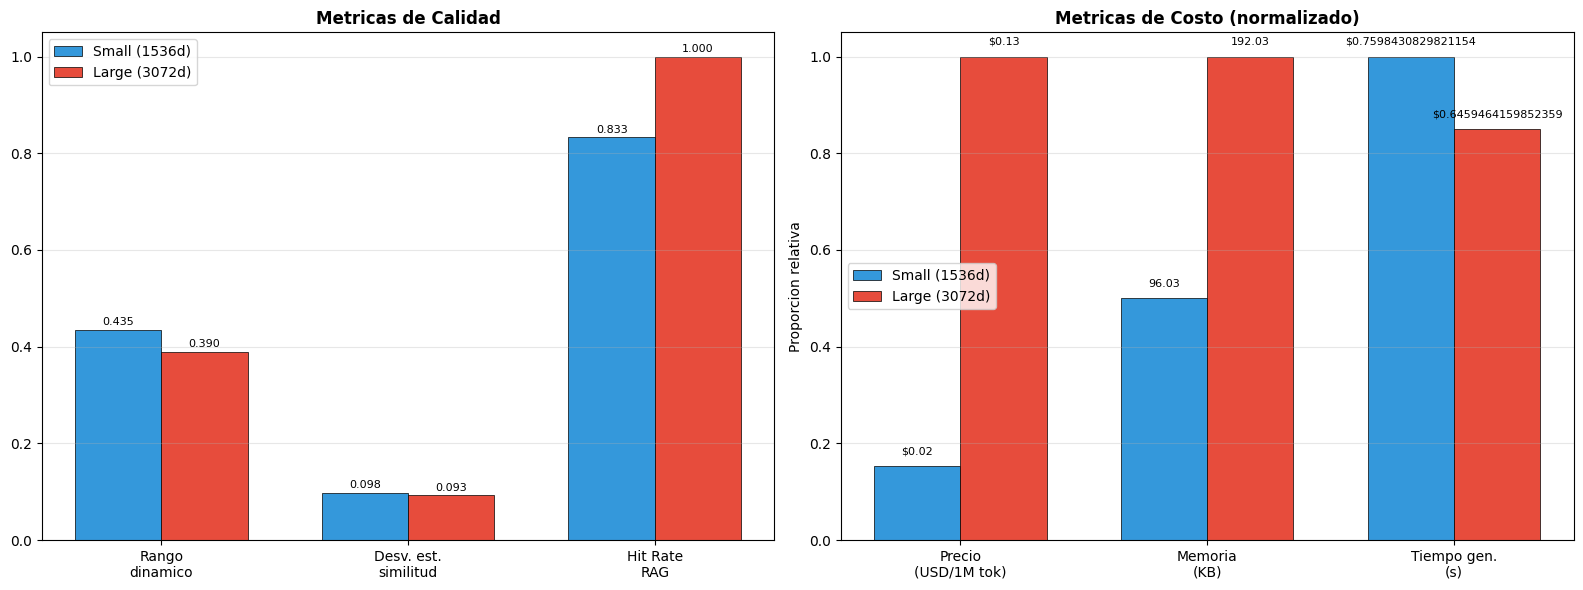

In [17]:
# Visualizacion: barras agrupadas 2-paneles (calidad vs costo)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Metricas de calidad (normalizadas para visualizacion)
calidad_labels = ["Rango\ndinamico", "Desv. est.\nsimilitud", "Hit Rate\nRAG"]
calidad_small = [rango_s, vals_small.std(), hit_rate_small]
calidad_large = [rango_l, vals_large.std(), hit_rate_large]

x = np.arange(len(calidad_labels))
width = 0.35

bars1 = axes[0].bar(x - width/2, calidad_small, width, label='Small (1536d)',
                     color='#3498db', edgecolor='black', linewidth=0.5)
bars2 = axes[0].bar(x + width/2, calidad_large, width, label='Large (3072d)',
                     color='#e74c3c', edgecolor='black', linewidth=0.5)
axes[0].set_xticks(x)
axes[0].set_xticklabels(calidad_labels)
axes[0].set_title('Metricas de Calidad', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

# Panel 2: Metricas de costo
costo_labels = ["Precio\n(USD/1M tok)", "Memoria\n(KB)", "Tiempo gen.\n(s)"]
costo_small = [PRECIO_SMALL, mem_small/1024, tiempo_small]
costo_large = [PRECIO_LARGE, mem_large/1024, tiempo_large]

# Normalizar para visualizacion (escala 0-1)
max_vals = [max(a, b) for a, b in zip(costo_small, costo_large)]
costo_small_norm = [v/m for v, m in zip(costo_small, max_vals)]
costo_large_norm = [v/m for v, m in zip(costo_large, max_vals)]

x2 = np.arange(len(costo_labels))
bars3 = axes[1].bar(x2 - width/2, costo_small_norm, width, label='Small (1536d)',
                     color='#3498db', edgecolor='black', linewidth=0.5)
bars4 = axes[1].bar(x2 + width/2, costo_large_norm, width, label='Large (3072d)',
                     color='#e74c3c', edgecolor='black', linewidth=0.5)
axes[1].set_xticks(x2)
axes[1].set_xticklabels(costo_labels)
axes[1].set_title('Metricas de Costo (normalizado)', fontweight='bold')
axes[1].set_ylabel('Proporcion relativa')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Anotaciones con valores reales
for bar, val in zip(bars3, costo_small):
    label = f"${val}" if isinstance(val, float) and val < 1 else f"{val:.2f}"
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 label, ha='center', va='bottom', fontsize=8)
for bar, val in zip(bars4, costo_large):
    label = f"${val}" if isinstance(val, float) and val < 1 else f"{val:.2f}"
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 label, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

---

## 11. Conclusiones

### Tabla de Decision: Cuando usar cada modelo

| Escenario | Modelo Recomendado | Razon |
|---|---|---|
| **Busqueda general** en documentos corporativos | `small` | Costo 6.5x menor, precision suficiente |
| **Clasificacion tematica** de textos | `small` | Separa bien temas distintos |
| **Analisis literario** con matices finos | `large` | Mejor rango dinamico para textos similares |
| **RAG sobre documentos tecnicos** | `small` | Vocabulario mas estandar, menos ambiguedad |
| **RAG sobre textos creativos/ambiguos** | `large` | Discrimina mejor entre contenidos similares |
| **Prototipo rapido** | `small` | Menor latencia y costo de experimentacion |
| **Produccion a gran escala** (millones de docs) | `small` | 50% menos almacenamiento y costo |
| **Busqueda semantica de alta precision** | `large` | Captura matices que `small` pierde |

### La analogia final

Volviendo a nuestra analogia de la camara:

- **Small (12MP)**: Perfecta para Instagram, documentos, uso diario. El 90% de las fotos no necesitan mas resolucion.
- **Large (24MP)**: Necesaria cuando haces zoom, cuando imprimes en gran formato, cuando cada detalle importa.

La decision no es tecnica sino de **negocio**: cuanto vale cada punto porcentual de precision en tu caso de uso?

### Checklist de Consolidacion

Verifica que puedes responder estas preguntas:

- [ ] Cuantas dimensiones tiene cada modelo y que implica eso en almacenamiento?
- [ ] Que es el rango dinamico de una matriz de similitud y por que importa?
- [ ] Como interpretar un heatmap de diferencia entre modelos?
- [ ] Que revela PCA vs t-SNE sobre la estructura de los embeddings?
- [ ] Como medir la granularidad semantica de un modelo de embeddings?
- [ ] Cuando el modelo `large` justifica su costo 6.5x mayor?
- [ ] Como afecta la eleccion del modelo de embeddings a un pipeline RAG?
- [ ] Que factores considerar al elegir un modelo para produccion?